# Benchmarks

This notebook will compare time and forward error of several methodologies to invert the Non-Linear Fourier Transform.

The tests will sample a random polynomial $b(z)$ with $\lVert b(z) \rVert_{\infty} = 1 - \eta = 0.5$ of increasing degrees and measure:
- The total runtime of completion + inversion in seconds.
- The completion forward error, computed as $\lVert |a(z)|^2 + |b(z)|^2 - 1 \rVert_{L^2}$;
- The inverse NLFT forward error, computed as $\lVert a - a' \rVert_{L^2} + \lVert b - b' \rVert_{L^2}$, i.e., the distance between the original completed $(a, b)$ and the final $(a', b')$ recomputed with the NLFT of the produced sequence;

In [1]:
from nlft_qsp.poly import Polynomial
from nlft_qsp.nlft import NonLinearFourierSequence
from nlft_qsp.rand import random_polynomial

from nlft_qsp.solvers import convolve_optimize, weiss, prony, layer_stripping, riemann_hilbert, half_cholesky, nlfft

import time

import matplotlib.pyplot as plt

NumpyBackend -- chosen dtypes: complex128, float64


In [2]:
def layer_stripping_convolveopt(b: Polynomial) -> tuple[Polynomial, NonLinearFourierSequence]:
    a = convolve_optimize.complete(b)
    return a, layer_stripping.inlft(a, b)

def layer_stripping_prony(b: Polynomial) -> tuple[Polynomial, NonLinearFourierSequence]:
    a = prony.complete(b)
    return a, layer_stripping.inlft(a, b)

def riemann_hilbert_weiss(b: Polynomial) -> tuple[Polynomial, NonLinearFourierSequence]:
    a, c = weiss.ratio(b)
    return a, riemann_hilbert.inlft(b, c)

def half_cholesky_weiss(b: Polynomial) -> tuple[Polynomial, NonLinearFourierSequence]:
    a, c = weiss.ratio(b)
    return a, half_cholesky.inlft(b, c)

def layer_stripping_weiss(b: Polynomial) -> tuple[Polynomial, NonLinearFourierSequence]:
    a = weiss.complete(b)
    return a, layer_stripping.inlft(a, b)

def nlfft_weiss(b: Polynomial) -> tuple[Polynomial, NonLinearFourierSequence]:
    a = weiss.complete(b)
    return a, nlfft.inlft(a, b)

In [ ]:
test_degrees = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]

test_algorithms = {
    #"LAYER_STRIP+CONVOPT":   layer_stripping_convolveopt,
    #"LAYER_STRIP+PRONY":     layer_stripping_prony,
    "RIEMANN_HILBERT+WEISS": riemann_hilbert_weiss,
    "HALF_CHOLESKY+WEISS":   half_cholesky_weiss,
    "LAYER_STRIP+WEISS":     layer_stripping_weiss,
    "NLFFT+WEISS":           nlfft_weiss
}

test_deg_limits = { # to avoid inefficient algorithms to take ages
    "LAYER_STRIP+CONVOPT":   10000, # O(n^2)
    "LAYER_STRIP+PRONY":     10000, # O(n^2)
    "RIEMANN_HILBERT+WEISS": 600,   # O(n^4)
    "HALF_CHOLESKY+WEISS":   10000, # O(n^2)
    "LAYER_STRIP+WEISS":     20000  # O(n^2)
}

test_results = {}
for k in test_algorithms.keys():
    test_results[k] = []

In [4]:
for n in test_degrees:
    print(f"Starting test degrees n = {n}.")
    b = random_polynomial(n+1, eta=0.5)
    
    for alg in test_algorithms.keys():
        print(f"\r- Algorithm {alg}                             ",end='')

        if alg in test_deg_limits and n > test_deg_limits[alg]:
            continue

        t0 = time.process_time_ns()
        a, F = test_algorithms[alg](b)
        t1 = time.process_time_ns()

        a2, b2 = F.transform()
        
        t = t1 - t0
        completion_err = (a * a.conjugate() + b * b.conjugate() - 1).l2_norm()
        inlft_err = (a2 - a).l2_norm() + (b2 - b).l2_norm()

        test_results[alg].append({ "degree": n, "time": t, "completion_err": completion_err, "inlft_err": inlft_err })
    print("\rdone.                             ")

Starting test degrees n = 5.
done.                                                         
Starting test degrees n = 10.
done.                                                         
Starting test degrees n = 20.
done.                                                         
Starting test degrees n = 50.
done.                                                         
Starting test degrees n = 100.
done.                                                         
Starting test degrees n = 200.
done.                                                         
Starting test degrees n = 500.
done.                                                         
Starting test degrees n = 1000.
done.                                                         
Starting test degrees n = 2000.
done.                                                         
Starting test degrees n = 5000.
done.                                                         
Starting test degrees n = 10000.
done.                        

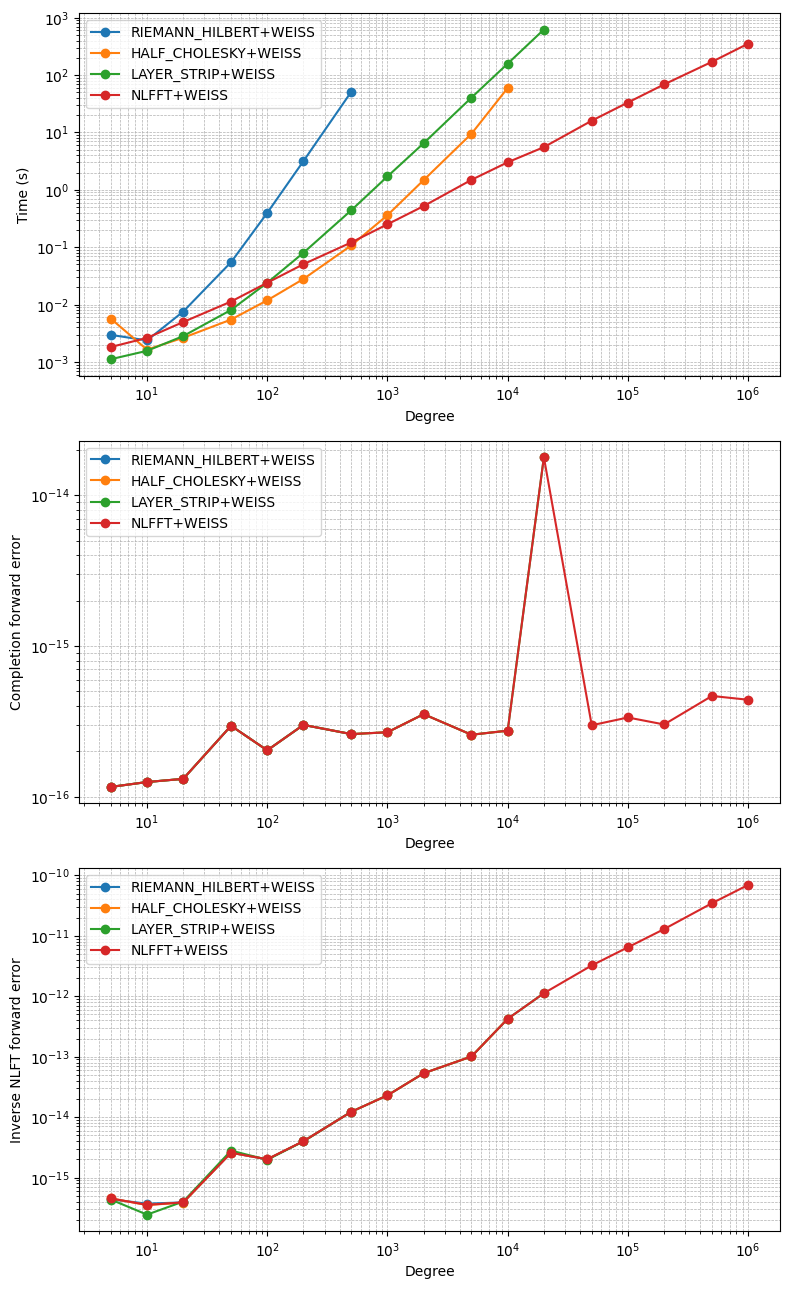

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(8, 13))

for label, results in test_results.items():
    degrees = [entry['degree'] for entry in results]
    times = [entry['time']/1000000000 for entry in results]
    comp_errs = [entry['completion_err'] for entry in results]
    inlft_errs = [entry['inlft_err'] for entry in results]

    axes[0].plot(degrees, times, marker='o', label=label)
    axes[1].plot(degrees, comp_errs, marker='o', label=label)
    axes[2].plot(degrees, inlft_errs, marker='o', label=label)

for ax, ylabel in zip(axes, ['Time (s)', 'Completion forward error', 'Inverse NLFT forward error']):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Degree')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, which='both', ls='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [6]:
from datetime import datetime
import json

current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

with open(f'benchmarks/benchmarks_{current_date}.json', 'w') as fp:
    json.dump(test_results, fp)